# ARIMA - how to determine p,d e q values
## p, d e q param
q: (int) MA model Order
p: (int) AR model Order
d: (int) number of time that data need to be differentiated

In [22]:
# As novas versões do Pandas e Matplotlib trazem diversas mensagens de aviso ao desenvolvedor. Vamos desativar isso.
import sys
import warnings
import matplotlib.cbook
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=matplotlib.cbook.mplDeprecation)

# Imports para manipulação de dados
import numpy as np
import pandas as pd
from datetime import datetime

# Imports para visualização de dados
import matplotlib.pyplot as plt
import matplotlib as m

# Imports para modelagem preditiva
import pmdarima
import statsmodels
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from pmdarima.arima.utils import ndiffs
from pandas.plotting import autocorrelation_plot

# Imports para métricas e performance do modelo
import math
from math import sqrt 
import sklearn
from sklearn.metrics import mean_squared_error 

# Imports para formatação dos gráficos
m.rcParams['axes.labelsize'] = 14
m.rcParams['xtick.labelsize'] = 12
m.rcParams['ytick.labelsize'] = 12
m.rcParams['text.color'] = 'k'
from matplotlib.pylab import rcParams 
rcParams['figure.figsize'] = 20,10

# Definição do Problema de Negócio
A HappyMoonVC é uma Venture Capital (VC).

Venture Capital (VC) é um tipo de fundo de investimento focado em capital de crescimento para empresas de médio porte que já possuem carteira de clientes e receita, mas que ainda precisam dar um salto de crescimento.

VCs investem em empresas iniciantes, Startups e emergentes que foram consideradas com alto potencial de crescimento ou que demonstraram alto crescimento (em termos de número de funcionários, receita anual ou ambos).

A HappyMoonVC está analisando um novo e promissor negócio sugerido por uma Startup, o GoInRail.

O GoInRail é um método de transporte inovador que usa a tecnologia de propulsão a jato para executar um veículo similar a um Drone, mas sobre trilhos (que mantém o Drone carregado com energia elétrica) e transportar pessoas em alta velocidade!

O investimento só fará sentido se o GoInRail conseguir mais de 1 milhão de usuários mensais nos próximos 18 meses.

Nosso trabalho é analisar dados de séries temporais com a demanda de transporte em uma determinada região e prever a demanda pelo GoInRail, que ajude a HappyMoonVC a tomar sua decisão de investimento.

In [7]:
# data
# we will use simulate data to show transportation customer demand

data_train = pd.read_csv("https://raw.githubusercontent.com/dsacademybr/Datasets/master/dataset4.csv")
dados_test = pd.read_csv("https://raw.githubusercontent.com/dsacademybr/Datasets/master/dataset5.csv")

In [8]:
# date time columns converter
data_train['Datetime'] = pd.to_datetime(data_train.Datetime, format = '%d-%m-%Y %H:%M')
dados_test['Datetime'] = pd.to_datetime(dados_test.Datetime, format= '%d-%m-%Y %H:%M')

In [9]:
for i in (data_train, dados_test):
    i['ano'] = i.Datetime.dt.year
    i['mes'] = i.Datetime.dt.month
    i['dia'] = i.Datetime.dt.day
    i['hora'] = i.Datetime.dt.hour

In [10]:
# week days extraction
data_train['dia_semana'] = data_train['Datetime'].dt.dayofweek
# if the days were 5 or 6 we set satuday and sunday like weekends
# after we create a function to mark the weekends

def converteWeekend(registro):
    if registro.dayofweek == 5 or registro.dayofweek == 6:
        return 1
    else:
        return 0


In [11]:
# Now we apply the function throw the data
data_train['final_semana'] = data_train['Datetime'].apply(converteWeekend)


In [12]:
# look data
data_train.head()


,ID,Datetime,Count,ano,mes,dia,hora,dia_semana,final_semana
0,0,2017-08-25 00:00:00,8,2017,8,25,0,4,0
1,1,2017-08-25 01:00:00,2,2017,8,25,1,4,0
2,2,2017-08-25 02:00:00,6,2017,8,25,2,4,0
3,3,2017-08-25 03:00:00,2,2017,8,25,3,4,0
4,4,2017-08-25 04:00:00,2,2017,8,25,4,4,0


In [13]:
# refine the data for the original series 

# set index to dataset
data_train.index=data_train['Datetime']


In [14]:
# remove ID column becase is not interesting for us
features = data_train.drop('ID',1)
# set target 
target = data_train['Count']

In [15]:
target

Datetime
2017-08-25 00:00:00      8
2017-08-25 01:00:00      2
2017-08-25 02:00:00      6
2017-08-25 03:00:00      2
2017-08-25 04:00:00      2
                      ... 
2019-09-25 19:00:00    868
2019-09-25 20:00:00    732
2019-09-25 21:00:00    702
2019-09-25 22:00:00    580
2019-09-25 23:00:00    534
Name: Count, Length: 18288, dtype: int64

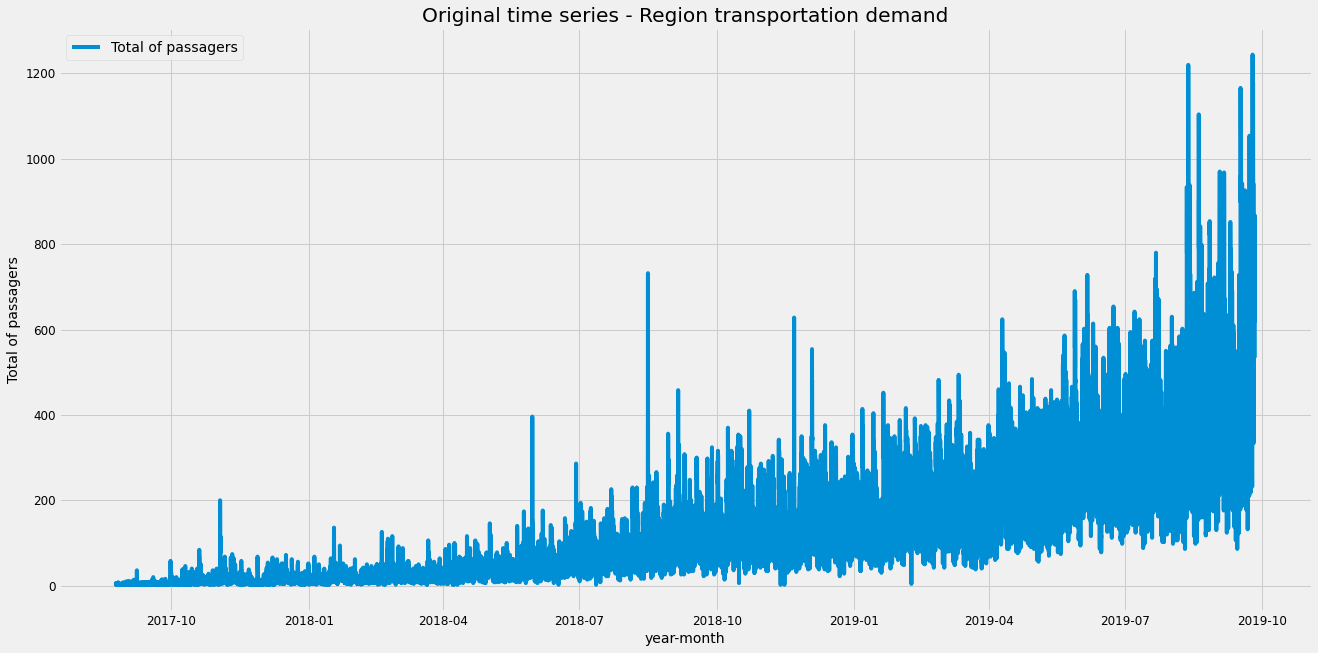

In [16]:
plt.title("Original time series - Region transportation demand")
plt.plot(target,label='Total of passagers')
plt.xlabel('year-month')
plt.ylabel('Total of passagers')
plt.legend(loc ='best')

# Determinando o valor do parâmetro d para o mmodelo ARIMA

O objetivo da diferenciação é tornar a serie temporal estacionária.
Mas você precisa ter cuidado para não superestimar a série. Por isso, uma série super diferenciada ainda pode ser estacionária, o que, por sua vez, afetará os parâmetros do modelo.
Então, como determinar a ordem correta de diferenciação?
A ordem correta de diferenciação é a diferenciação minima necessária para obter uma série quase estacionária que circula em torno de uma média definida e o gráfico ACF chega a zero rapidamente.

Se as autocorrelações foram positicas para muitos atrasos(10 ou mais), a série precisará ser diferenciada, Por outro lado, se a autocorrelação lag 1 em si for muito negativa, a série provavelmente será super diferenciada.

se não for possivel realmente decidir entre duas ordens de diferenciação então a ordem que apresenta o menor desvio padrão na série diferenciada.
Vamos ver como fazer isso com um exemplo
Primeiro, vou verificar se a série é estacionária usando o teste Augemented Dickey (adfuller()), do pacote statsmodels
Por quê?
Porque você precisa diferenciar apenas se a série não for estacionária. Senão, nenhuma diferenciação é necessária, ou seja, d=0, a hipótese nula do teste ADF é que a série temporal não é estacionária. Portanto, se o valor-p do teste for menor que o nivel de significância(0.05), voĉe rejeitará a hipótese nula e poderá inferir que a série temporal é realmente estacinária
Portando, se o valor-p > 0.05, prosseguimos em busca da ordem da diferenciação.
Vamos aplicar o teste ADF mais uma vez em nossa série:


In [17]:
# test ADF
result = adfuller(data_train['Count'])
print('Stats ADF: %f'% result[0])
print('value-p: %f'% result[1])

Stats ADF: -4.456561
value-p: 0.000235


O valor p é menor que 0.05 portanto, não precisamos calcular o valor de 'd', ou seja, d=0 no Modelo ARIMA
Entretanto, vamos fazer mais uma checagem. Vamos aplicar a diferenciação, duas vezes a nossa série e comparar os gráficos ACF.
A função np.diff() aplica a diferenciação.

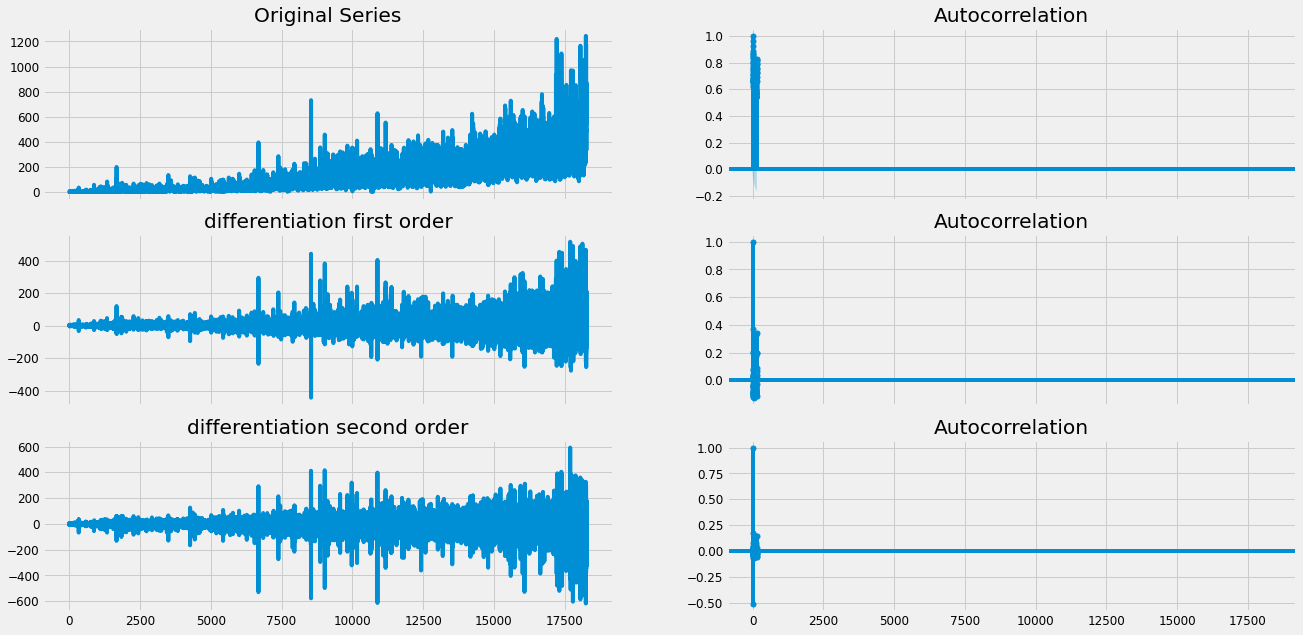

In [24]:
# plot area
fig,axes = plt.subplots(3,2,sharex=True)

# original series
axes[0,0].plot(target.values); axes[0,0].set_title('Original Series')
plot_acf(target.values,lags =150, ax = axes[0,1])

# differentiation first order
axes[1,0].plot(np.diff(target.values));axes[1,0].set_title('differentiation first order')
plot_acf(np.diff(target.values),lags=150,ax =axes[1,1])

# differentiation second order
axes[2,0].plot(np.diff(np.diff(target.values))); axes[2,0].set_title('differentiation second order')
plot_acf(np.diff(np.diff(target.values)),lags=150,ax = axes[2,1])
plt.show()

Fica claro que a Diferenciação de primeira Ordem distribuiu melhor a série. Ou seja, o valor d=1 parece ser uma boa opção para o modelo ARIMA.
Mas a diferenciação de primeira e segunda ordem estão bem parecidas, Por que não d=2?
Afinal, a série temporal atinge a estacionariedade com duas ordens de diferenciação, mas, olhando para o gráfico de autocorrelação para o segundo diferencial, o atraso (lag) entra na zona negativa distante (0-.5) razoavelmente rápido, o que indica que a série pode ter sido super diferenciada.
Portanto a diferenciação de primeira ordem parece ser mesmo a melhor opção mesmo que a série não seja perfeitamente estacionária (fraca estacionariedade). Ou seja, d=1.

Mas espere, tenho mais um teste com a função ndiffs:
https://alkaline-ml.com/pmdarima/modules/generated/pmdarima.arima.ndiffs.html


In [25]:
# test ADF
ndiffs(target,test='adf')


0

In [26]:
# test KPSS
ndiffs(target,test = 'kpss')

1

Ou seja, o teste ADF incivou d=0 e o teste kpss indicou d=1
vamos escolher d=1 pois vimos no gráfico a diferenciação, A ecolha é do cientista de dados.
já temos o i de ARIMA, o parâmetro d. Agora vamos encontrar o termo AR, com o parâmetro p.



# determinando o valor do parâmetro p para o modelo ARIMA

A próxima etapa é identificar se o modelo precisa de termos AR. VocÊ pode descobrir o número necessário de termos AR, inspecionando o gráfico PACF ( Partial Autocorrelation). Mas o que é PACF?

A autocorrelação parcial pode ser imaginada como a correlação entre a série e seu atraso aós excluir as contribuições dos atrasos intermediários. Portando, o PACF  meio que transmite a correlação pura entre um atraso e a série. Dessa forma, você saverá se esse atraso é necessário no termo AR ou não.

Qualquer autocorrelação em uma série estacionarizada pode ser retificada adcionando termos AR suficientes. Portanto, inicialmente consideramos a ordem de termos AR igual a tantas defasagens que ultrapassam o limite de significância no gráfico PACF.


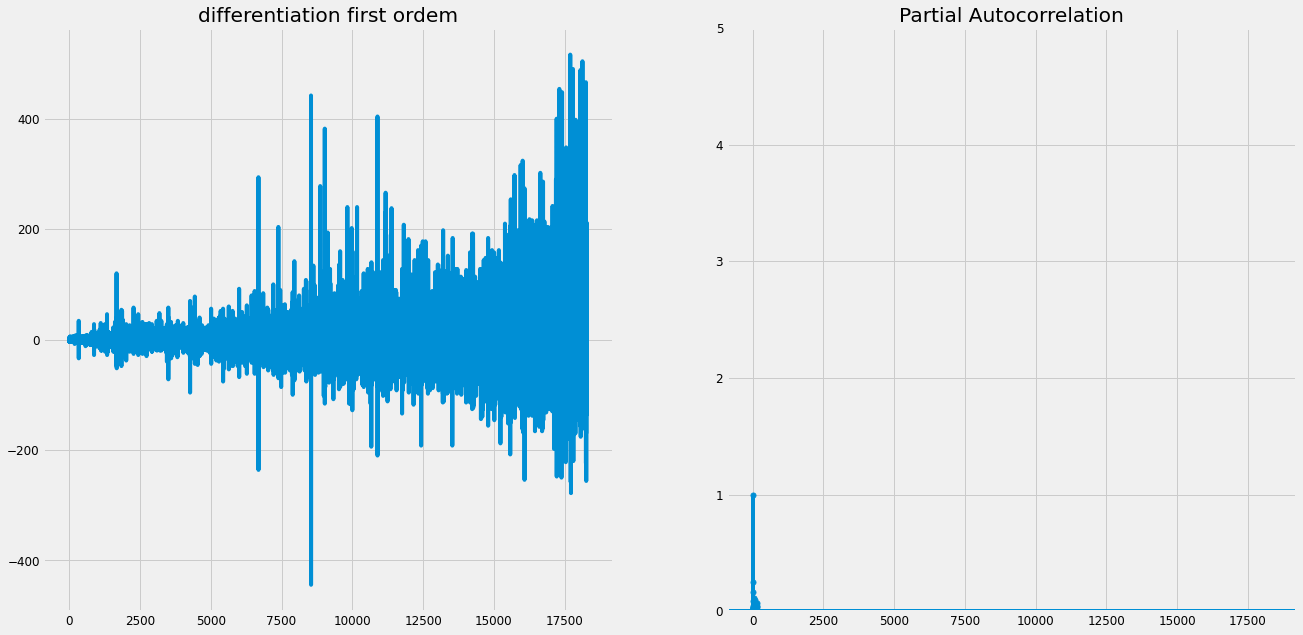

In [30]:
# gráfico PACF
fig,axes = plt.subplots(1,2,sharex=True)
axes[0].plot(np.diff(target.values));axes[0].set_title('differentiation first ordem')
axes[1].set(ylim=(0,5))
plot_pacf(np.diff(target.values), lags=150, ax = axes[1])
plt.show()

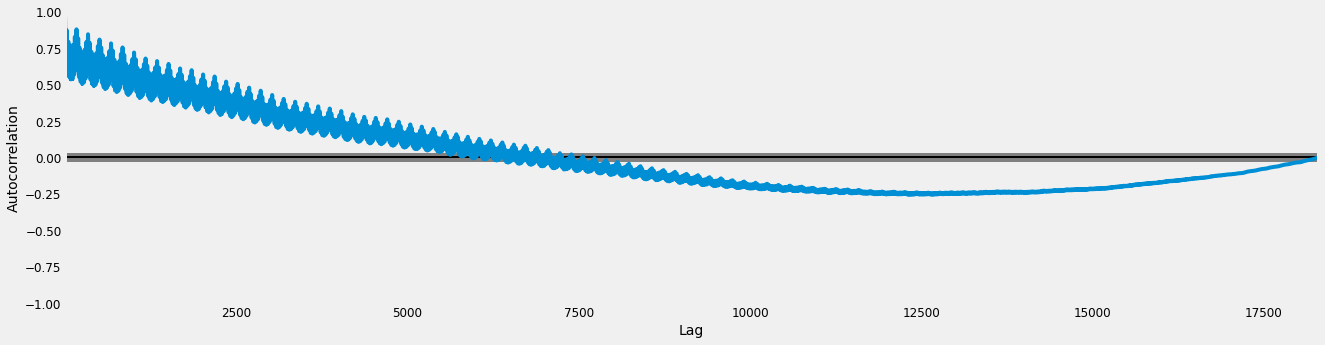

In [31]:
# autocorrelation plot
plt.figure(figsize=[20,5])
autocorrelation_plot(target)
plt.show()

O gráfico de autocorrelação indica que temos pelo menos um valor acima do limite de 0.2 ou seja, q=1 é o minimo que deveríamos testar,
embora o q=2 seja uma opção. Você pode testar as duas opções se desejar, mas eu vou escolher q=1.

Para quem gosta de regras, aqui está uma lista completa
https://people.duke.edu/~rnau/arimrule.htm

já temos os 3 parâmetros para o modelo ARIMA(p,d,q)-order(1,1,1).
